In [1]:
import numpy as np
import pandas as pd
import random 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10, FashionMNIST
import torchmetrics

# Prepare data

In [2]:
traindata = CIFAR10(root='data',train=True, download=True, transform=ToTensor(), target_transform=None)
testdata = CIFAR10(root='data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(traindata.data),len(traindata.targets), len(testdata.data), len(testdata.targets) 

In [ ]:
class_names = traindata.classes
class_names

In [ ]:
image, label = traindata[0]
image = image.permute(1, 2, 0)
plt.imshow(image.squeeze())
plt.title(label)
plt.show()

In [ ]:
image.shape

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
BATCH_SIZE = 32
IMAGE_SIZE = 32
# lr = 0.1

In [4]:
trainloader = DataLoader(traindata, batch_size = BATCH_SIZE, shuffle=True)
testloader = DataLoader(testdata, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
next(iter(trainloader))

In [ ]:
%pip install torchsummary

# MLP with 2 hidden layers

In [5]:
# MLP with 2 hidden layers
class MLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, activation_fn: str = 'ReLU', activate: bool=False):
        super(MLP, self).__init__()
        # Define activation functions based on the parameter
        if activation_fn == 'ReLU':
            self.activation_fn = nn.ReLU()
        elif activation_fn == 'Sigmoid':
            self.activation_fn = nn.Sigmoid()
        elif activation_fn == 'Tanh':
            self.activation_fn = nn.Tanh()
        elif activation_fn == 'LeakyReLU':
            self.activation_fn = nn.LeakyReLU()
        else:
            raise ValueError(f"Unsupported activation function: {activation_fn}")
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    
    def forward(self, x):
        out = self.layer_stack(x)
        return out

model = MLP(input_shape=3*IMAGE_SIZE**2, hidden_units=10, output_shape=10).to(device)
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
            Linear-3                   [-1, 10]             110
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [6]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
acc_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=10).to(device)

In [7]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_cost, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_cost += loss
        train_acc += acc_fn(y_pred.argmax(dim=1), y)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_cost /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train loss: {train_cost:.5f} | Train accuracy: {train_acc:.2f}")
    return train_cost, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              acc_fn,
              device: torch.device = device):
    test_cost, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_cost += loss_fn(test_pred, y)
            test_acc += acc_fn(test_pred.argmax(dim=1), y)
       

        # Adjust metrics and print out
        test_cost /= len(data_loader)
        test_acc /= len(data_loader)
       
        print(f"Test loss: {test_cost:.5f} | Test accuracy: {test_acc:.2f}")
    return test_cost, test_acc

In [8]:
def plot_training_testing_results(total_train_cost, total_test_cost, total_train_acc, total_test_acc):
    """
    Function to plot the training and testing loss, and training and testing accuracy.
    
    Args:
        total_train_cost (list): List of training losses for each epoch.
        total_test_cost (list): List of testing losses for each epoch.
        total_train_acc (list): List of training accuracies for each epoch.
        total_test_acc (list): List of testing accuracies for each epoch.
    """
    plt.figure(figsize=(12, 6))

    # Plot training and testing loss
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(range(EPOCHS), total_train_cost, label='Training Loss')
    plt.plot(range(EPOCHS), total_test_cost, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot training and testing accuracy
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    plt.plot(range(EPOCHS), total_train_acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), total_test_acc, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()  # Adjust spacing between subplots for better display
    plt.show()

def visualize(model):
    model.eval()
    with torch.no_grad():
        idx = random.randint(0, len(testloader.dataset) - 1)
        image, label = testloader.dataset[idx]
        image = image.unsqueeze(0).to(device)

        output = model(image)
        pred = output.argmax(dim=1)
        print(f"Preds: {pred.item()} | True: {label}")
        image = image.cpu().squeeze().permute(1, 2, 0).numpy()

        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [9]:
torch.manual_seed(42)
total_train_cost = []
total_train_acc = []
total_test_cost = []
total_test_acc = []
# Can customize how often you do a testing step
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_cost, train_acc = train_step(data_loader=trainloader,
        model=model,
        loss_fn=criterion,
        acc_fn = acc_fn,
        optimizer=optimizer,
        device = device
    )
    total_train_cost.append(train_cost.cpu().detach().numpy())
    total_train_acc.append(train_acc.cpu().detach().numpy())
    test_cost, test_acc = test_step(data_loader=testloader,
        model=model,
        loss_fn=criterion,
        acc_fn = acc_fn,
        device = device
    )
    total_test_cost.append(test_cost.cpu().detach().numpy())
    total_test_acc.append(test_acc.cpu().detach().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.91070 | Train accuracy: 0.32


  2%|▏         | 1/50 [00:12<10:12, 12.49s/it]

Test loss: 1.82978 | Test accuracy: 0.35
Epoch: 1
---------
Train loss: 1.80295 | Train accuracy: 0.37


  4%|▍         | 2/50 [00:24<09:46, 12.21s/it]

Test loss: 1.78120 | Test accuracy: 0.37
Epoch: 2
---------
Train loss: 1.77931 | Train accuracy: 0.38


  6%|▌         | 3/50 [00:36<09:28, 12.10s/it]

Test loss: 1.78718 | Test accuracy: 0.37
Epoch: 3
---------
Train loss: 1.76376 | Train accuracy: 0.39


  8%|▊         | 4/50 [00:48<09:17, 12.12s/it]

Test loss: 1.77420 | Test accuracy: 0.38
Epoch: 4
---------
Train loss: 1.75553 | Train accuracy: 0.39


 10%|█         | 5/50 [01:00<09:05, 12.12s/it]

Test loss: 1.83376 | Test accuracy: 0.36
Epoch: 5
---------
Train loss: 1.74569 | Train accuracy: 0.39


 12%|█▏        | 6/50 [01:12<08:52, 12.09s/it]

Test loss: 1.74995 | Test accuracy: 0.39
Epoch: 6
---------
Train loss: 1.73942 | Train accuracy: 0.40


 14%|█▍        | 7/50 [01:24<08:38, 12.05s/it]

Test loss: 1.74442 | Test accuracy: 0.39
Epoch: 7
---------
Train loss: 1.73532 | Train accuracy: 0.40


 16%|█▌        | 8/50 [01:36<08:25, 12.02s/it]

Test loss: 1.75380 | Test accuracy: 0.38
Epoch: 8
---------
Train loss: 1.72616 | Train accuracy: 0.40


 18%|█▊        | 9/50 [01:48<08:13, 12.04s/it]

Test loss: 1.75300 | Test accuracy: 0.39
Epoch: 9
---------
Train loss: 1.72502 | Train accuracy: 0.40


 20%|██        | 10/50 [02:00<08:01, 12.03s/it]

Test loss: 1.74305 | Test accuracy: 0.40
Epoch: 10
---------
Train loss: 1.72070 | Train accuracy: 0.41


 22%|██▏       | 11/50 [02:12<07:48, 12.01s/it]

Test loss: 1.74116 | Test accuracy: 0.40
Epoch: 11
---------
Train loss: 1.71831 | Train accuracy: 0.41


 24%|██▍       | 12/50 [02:24<07:36, 12.00s/it]

Test loss: 1.73596 | Test accuracy: 0.39
Epoch: 12
---------
Train loss: 1.71366 | Train accuracy: 0.41


 26%|██▌       | 13/50 [02:36<07:24, 12.02s/it]

Test loss: 1.74856 | Test accuracy: 0.39
Epoch: 13
---------
Train loss: 1.71151 | Train accuracy: 0.41


 28%|██▊       | 14/50 [02:48<07:14, 12.06s/it]

Test loss: 1.72653 | Test accuracy: 0.40
Epoch: 14
---------
Train loss: 1.71117 | Train accuracy: 0.41


 30%|███       | 15/50 [03:00<07:00, 12.02s/it]

Test loss: 1.73897 | Test accuracy: 0.40
Epoch: 15
---------
Train loss: 1.71093 | Train accuracy: 0.41


 32%|███▏      | 16/50 [03:12<06:47, 11.99s/it]

Test loss: 1.72745 | Test accuracy: 0.40
Epoch: 16
---------
Train loss: 1.70620 | Train accuracy: 0.41


 34%|███▍      | 17/50 [03:24<06:35, 11.97s/it]

Test loss: 1.80444 | Test accuracy: 0.38
Epoch: 17
---------
Train loss: 1.70449 | Train accuracy: 0.41


 36%|███▌      | 18/50 [03:36<06:22, 11.95s/it]

Test loss: 1.72597 | Test accuracy: 0.40
Epoch: 18
---------
Train loss: 1.70094 | Train accuracy: 0.42


 38%|███▊      | 19/50 [03:48<06:10, 11.94s/it]

Test loss: 1.72535 | Test accuracy: 0.40
Epoch: 19
---------
Train loss: 1.69795 | Train accuracy: 0.42


 40%|████      | 20/50 [04:00<06:00, 12.03s/it]

Test loss: 1.74179 | Test accuracy: 0.39
Epoch: 20
---------
Train loss: 1.69907 | Train accuracy: 0.42


 42%|████▏     | 21/50 [04:12<05:49, 12.06s/it]

Test loss: 1.72369 | Test accuracy: 0.40
Epoch: 21
---------
Train loss: 1.69493 | Train accuracy: 0.42


 44%|████▍     | 22/50 [04:25<05:40, 12.16s/it]

Test loss: 1.75613 | Test accuracy: 0.39
Epoch: 22
---------
Train loss: 1.69361 | Train accuracy: 0.42


 46%|████▌     | 23/50 [04:37<05:29, 12.22s/it]

Test loss: 1.73164 | Test accuracy: 0.40
Epoch: 23
---------
Train loss: 1.69172 | Train accuracy: 0.42


 48%|████▊     | 24/50 [04:49<05:17, 12.23s/it]

Test loss: 1.71948 | Test accuracy: 0.40
Epoch: 24
---------
Train loss: 1.69118 | Train accuracy: 0.42


 50%|█████     | 25/50 [05:02<05:05, 12.21s/it]

Test loss: 1.75660 | Test accuracy: 0.39
Epoch: 25
---------
Train loss: 1.68859 | Train accuracy: 0.42


 52%|█████▏    | 26/50 [05:14<04:52, 12.21s/it]

Test loss: 1.71184 | Test accuracy: 0.41
Epoch: 26
---------
Train loss: 1.68852 | Train accuracy: 0.42


 54%|█████▍    | 27/50 [05:26<04:41, 12.24s/it]

Test loss: 1.72858 | Test accuracy: 0.41
Epoch: 27
---------
Train loss: 1.69109 | Train accuracy: 0.42


 56%|█████▌    | 28/50 [05:38<04:28, 12.20s/it]

Test loss: 1.71358 | Test accuracy: 0.40
Epoch: 28
---------
Train loss: 1.68608 | Train accuracy: 0.42


 58%|█████▊    | 29/50 [05:50<04:14, 12.14s/it]

Test loss: 1.75289 | Test accuracy: 0.38
Epoch: 29
---------
Train loss: 1.68277 | Train accuracy: 0.42


 60%|██████    | 30/50 [06:02<04:02, 12.12s/it]

Test loss: 1.76442 | Test accuracy: 0.38
Epoch: 30
---------
Train loss: 1.68214 | Train accuracy: 0.42


 62%|██████▏   | 31/50 [06:14<03:49, 12.08s/it]

Test loss: 1.76005 | Test accuracy: 0.39
Epoch: 31
---------
Train loss: 1.68127 | Train accuracy: 0.42


 64%|██████▍   | 32/50 [06:26<03:37, 12.09s/it]

Test loss: 1.71565 | Test accuracy: 0.40
Epoch: 32
---------
Train loss: 1.68215 | Train accuracy: 0.42


 66%|██████▌   | 33/50 [06:38<03:25, 12.08s/it]

Test loss: 1.71461 | Test accuracy: 0.41
Epoch: 33
---------
Train loss: 1.67969 | Train accuracy: 0.42


 68%|██████▊   | 34/50 [06:51<03:13, 12.08s/it]

Test loss: 1.72743 | Test accuracy: 0.40
Epoch: 34
---------
Train loss: 1.67867 | Train accuracy: 0.42


 70%|███████   | 35/50 [07:03<03:01, 12.13s/it]

Test loss: 1.73666 | Test accuracy: 0.40
Epoch: 35
---------
Train loss: 1.67916 | Train accuracy: 0.42


 72%|███████▏  | 36/50 [07:15<02:50, 12.15s/it]

Test loss: 1.72847 | Test accuracy: 0.40
Epoch: 36
---------
Train loss: 1.67777 | Train accuracy: 0.43


 74%|███████▍  | 37/50 [07:27<02:38, 12.18s/it]

Test loss: 1.74943 | Test accuracy: 0.39
Epoch: 37
---------
Train loss: 1.67598 | Train accuracy: 0.42


 76%|███████▌  | 38/50 [07:40<02:26, 12.23s/it]

Test loss: 1.75298 | Test accuracy: 0.39
Epoch: 38
---------
Train loss: 1.67490 | Train accuracy: 0.43


 78%|███████▊  | 39/50 [07:52<02:14, 12.24s/it]

Test loss: 1.73862 | Test accuracy: 0.39
Epoch: 39
---------
Train loss: 1.67532 | Train accuracy: 0.43


 80%|████████  | 40/50 [08:04<02:02, 12.28s/it]

Test loss: 1.73794 | Test accuracy: 0.40
Epoch: 40
---------
Train loss: 1.67572 | Train accuracy: 0.43


 82%|████████▏ | 41/50 [08:17<01:51, 12.34s/it]

Test loss: 1.73454 | Test accuracy: 0.40
Epoch: 41
---------
Train loss: 1.67368 | Train accuracy: 0.43


 84%|████████▍ | 42/50 [08:29<01:38, 12.30s/it]

Test loss: 1.72834 | Test accuracy: 0.40
Epoch: 42
---------
Train loss: 1.67243 | Train accuracy: 0.43


 86%|████████▌ | 43/50 [08:41<01:26, 12.32s/it]

Test loss: 1.71993 | Test accuracy: 0.41
Epoch: 43
---------
Train loss: 1.67030 | Train accuracy: 0.43


 88%|████████▊ | 44/50 [08:53<01:13, 12.24s/it]

Test loss: 1.72087 | Test accuracy: 0.41
Epoch: 44
---------
Train loss: 1.67188 | Train accuracy: 0.43


 90%|█████████ | 45/50 [09:06<01:01, 12.24s/it]

Test loss: 1.71750 | Test accuracy: 0.40
Epoch: 45
---------
Train loss: 1.67152 | Train accuracy: 0.43


 92%|█████████▏| 46/50 [09:18<00:48, 12.21s/it]

Test loss: 1.73032 | Test accuracy: 0.40
Epoch: 46
---------
Train loss: 1.66972 | Train accuracy: 0.43


 94%|█████████▍| 47/50 [09:30<00:36, 12.23s/it]

Test loss: 1.72300 | Test accuracy: 0.40
Epoch: 47
---------
Train loss: 1.66917 | Train accuracy: 0.43


 96%|█████████▌| 48/50 [09:42<00:24, 12.29s/it]

Test loss: 1.73920 | Test accuracy: 0.40
Epoch: 48
---------
Train loss: 1.66867 | Train accuracy: 0.43


 98%|█████████▊| 49/50 [09:55<00:12, 12.46s/it]

Test loss: 1.71733 | Test accuracy: 0.41
Epoch: 49
---------
Train loss: 1.66860 | Train accuracy: 0.43


100%|██████████| 50/50 [10:08<00:00, 12.17s/it]

Test loss: 1.72264 | Test accuracy: 0.40


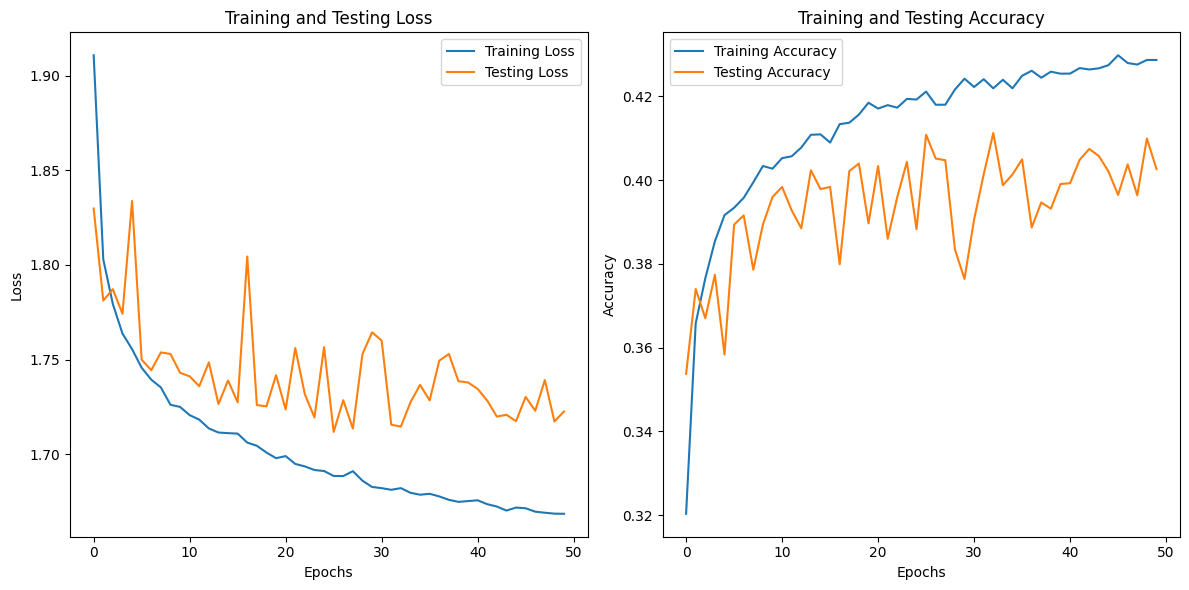

Preds: 3 | True: 2


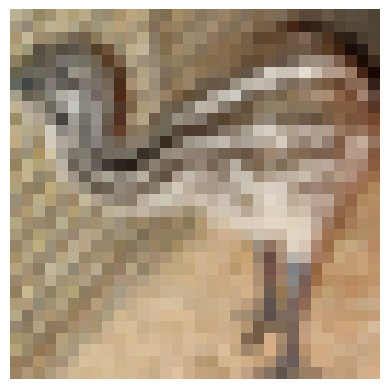

In [10]:
plot_training_testing_results(total_test_cost=total_test_cost, total_train_acc=total_train_acc, total_test_acc=total_test_acc, total_train_cost=total_train_cost)
visualize(model)

# MLP with one hidden layer

In [13]:
class MLPv1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(MLPv1, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=output_shape),
        )
    
    def forward(self, x):
        out = self.layer_stack(x)
        return out

modelv1 = MLPv1(input_shape=3*IMAGE_SIZE**2, hidden_units=10, output_shape=10).to(device)
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
            Linear-3                   [-1, 10]             110
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [14]:
optimizer = torch.optim.Adam(modelv1.parameters())
criterion = nn.CrossEntropyLoss()
acc_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=10).to(device)

In [15]:
torch.manual_seed(42)
total_train_cost = []
total_train_acc = []
total_test_cost = []
total_test_acc = []
# Can customize how often you do a testing step
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_cost, train_acc = train_step(data_loader=trainloader,
        model=modelv1,
        loss_fn=criterion,
        acc_fn = acc_fn,
        optimizer=optimizer,
        device = device
    )
    total_train_cost.append(train_cost.cpu().detach().numpy())
    total_train_acc.append(train_acc.cpu().detach().numpy())
    test_cost, test_acc = test_step(data_loader=testloader,
        model=modelv1,
        loss_fn=criterion,
        acc_fn = acc_fn,
        device = device
    )
    total_test_cost.append(test_cost.cpu().detach().numpy())
    total_test_acc.append(test_acc.cpu().detach().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.95865 | Train accuracy: 0.32


  2%|▏         | 1/50 [00:11<09:40, 11.85s/it]

Test loss: 1.84111 | Test accuracy: 0.36
Epoch: 1
---------
Train loss: 1.87717 | Train accuracy: 0.36


  4%|▍         | 2/50 [00:23<09:33, 11.96s/it]

Test loss: 2.05653 | Test accuracy: 0.32
Epoch: 2
---------
Train loss: 1.84919 | Train accuracy: 0.37


  6%|▌         | 3/50 [00:35<09:23, 11.99s/it]

Test loss: 1.87783 | Test accuracy: 0.35
Epoch: 3
---------
Train loss: 1.83367 | Train accuracy: 0.37


  8%|▊         | 4/50 [00:48<09:13, 12.04s/it]

Test loss: 1.94915 | Test accuracy: 0.32
Epoch: 4
---------
Train loss: 1.83572 | Train accuracy: 0.37


 10%|█         | 5/50 [01:00<09:06, 12.15s/it]

Test loss: 1.98679 | Test accuracy: 0.34
Epoch: 5
---------
Train loss: 1.82465 | Train accuracy: 0.37


 12%|█▏        | 6/50 [01:12<08:56, 12.20s/it]

Test loss: 1.74802 | Test accuracy: 0.40
Epoch: 6
---------
Train loss: 1.81749 | Train accuracy: 0.38


 14%|█▍        | 7/50 [01:24<08:44, 12.19s/it]

Test loss: 1.85494 | Test accuracy: 0.36
Epoch: 7
---------
Train loss: 1.80783 | Train accuracy: 0.38


 16%|█▌        | 8/50 [01:37<08:32, 12.20s/it]

Test loss: 1.83823 | Test accuracy: 0.36
Epoch: 8
---------
Train loss: 1.81402 | Train accuracy: 0.38


 18%|█▊        | 9/50 [01:49<08:19, 12.18s/it]

Test loss: 1.87754 | Test accuracy: 0.35
Epoch: 9
---------
Train loss: 1.80350 | Train accuracy: 0.39


 20%|██        | 10/50 [02:01<08:07, 12.19s/it]

Test loss: 1.92871 | Test accuracy: 0.35
Epoch: 10
---------
Train loss: 1.79276 | Train accuracy: 0.39


 22%|██▏       | 11/50 [02:13<07:54, 12.16s/it]

Test loss: 1.84855 | Test accuracy: 0.36
Epoch: 11
---------
Train loss: 1.80086 | Train accuracy: 0.39


 24%|██▍       | 12/50 [02:25<07:42, 12.17s/it]

Test loss: 1.91206 | Test accuracy: 0.35
Epoch: 12
---------
Train loss: 1.79025 | Train accuracy: 0.39


 26%|██▌       | 13/50 [02:37<07:26, 12.08s/it]

Test loss: 2.02183 | Test accuracy: 0.33
Epoch: 13
---------
Train loss: 1.79606 | Train accuracy: 0.39


 28%|██▊       | 14/50 [02:49<07:15, 12.10s/it]

Test loss: 1.80693 | Test accuracy: 0.38
Epoch: 14
---------
Train loss: 1.78534 | Train accuracy: 0.39


 30%|███       | 15/50 [03:01<07:03, 12.11s/it]

Test loss: 1.83221 | Test accuracy: 0.36
Epoch: 15
---------
Train loss: 1.79223 | Train accuracy: 0.39


 32%|███▏      | 16/50 [03:13<06:50, 12.06s/it]

Test loss: 1.86413 | Test accuracy: 0.37
Epoch: 16
---------
Train loss: 1.78382 | Train accuracy: 0.39


 34%|███▍      | 17/50 [03:25<06:36, 12.00s/it]

Test loss: 1.91553 | Test accuracy: 0.35
Epoch: 17
---------
Train loss: 1.78526 | Train accuracy: 0.39


 36%|███▌      | 18/50 [03:37<06:22, 11.97s/it]

Test loss: 1.85837 | Test accuracy: 0.37
Epoch: 18
---------
Train loss: 1.77599 | Train accuracy: 0.40


 38%|███▊      | 19/50 [03:49<06:09, 11.92s/it]

Test loss: 2.06770 | Test accuracy: 0.33
Epoch: 19
---------
Train loss: 1.77170 | Train accuracy: 0.40


 40%|████      | 20/50 [04:01<05:57, 11.92s/it]

Test loss: 1.85679 | Test accuracy: 0.37
Epoch: 20
---------
Train loss: 1.77145 | Train accuracy: 0.40


 42%|████▏     | 21/50 [04:13<05:44, 11.89s/it]

Test loss: 2.03747 | Test accuracy: 0.34
Epoch: 21
---------
Train loss: 1.76928 | Train accuracy: 0.40


 44%|████▍     | 22/50 [04:24<05:32, 11.86s/it]

Test loss: 1.87940 | Test accuracy: 0.36
Epoch: 22
---------
Train loss: 1.76975 | Train accuracy: 0.40


 46%|████▌     | 23/50 [04:36<05:21, 11.91s/it]

Test loss: 1.84941 | Test accuracy: 0.37
Epoch: 23
---------
Train loss: 1.77499 | Train accuracy: 0.40


 48%|████▊     | 24/50 [04:48<05:09, 11.90s/it]

Test loss: 1.81202 | Test accuracy: 0.38
Epoch: 24
---------
Train loss: 1.77020 | Train accuracy: 0.40


 50%|█████     | 25/50 [05:00<04:56, 11.87s/it]

Test loss: 1.88695 | Test accuracy: 0.36
Epoch: 25
---------
Train loss: 1.76063 | Train accuracy: 0.40


 52%|█████▏    | 26/50 [05:12<04:45, 11.90s/it]

Test loss: 1.84824 | Test accuracy: 0.36
Epoch: 26
---------
Train loss: 1.76060 | Train accuracy: 0.40


 54%|█████▍    | 27/50 [05:24<04:33, 11.90s/it]

Test loss: 1.81265 | Test accuracy: 0.38
Epoch: 27
---------
Train loss: 1.76197 | Train accuracy: 0.40


 56%|█████▌    | 28/50 [05:36<04:23, 11.96s/it]

Test loss: 1.83136 | Test accuracy: 0.37
Epoch: 28
---------
Train loss: 1.75684 | Train accuracy: 0.40


 58%|█████▊    | 29/50 [05:48<04:10, 11.93s/it]

Test loss: 1.86245 | Test accuracy: 0.37
Epoch: 29
---------
Train loss: 1.76363 | Train accuracy: 0.40


 60%|██████    | 30/50 [06:00<03:58, 11.92s/it]

Test loss: 1.79815 | Test accuracy: 0.38
Epoch: 30
---------
Train loss: 1.75723 | Train accuracy: 0.40


 62%|██████▏   | 31/50 [06:12<03:46, 11.90s/it]

Test loss: 1.83440 | Test accuracy: 0.37
Epoch: 31
---------
Train loss: 1.75549 | Train accuracy: 0.40


 64%|██████▍   | 32/50 [06:24<03:34, 11.90s/it]

Test loss: 1.90479 | Test accuracy: 0.36
Epoch: 32
---------
Train loss: 1.75226 | Train accuracy: 0.40


 66%|██████▌   | 33/50 [06:35<03:21, 11.87s/it]

Test loss: 2.01119 | Test accuracy: 0.32
Epoch: 33
---------
Train loss: 1.75761 | Train accuracy: 0.41


 68%|██████▊   | 34/50 [06:47<03:09, 11.86s/it]

Test loss: 1.79147 | Test accuracy: 0.39
Epoch: 34
---------
Train loss: 1.75282 | Train accuracy: 0.41


 70%|███████   | 35/50 [06:59<02:57, 11.83s/it]

Test loss: 1.89801 | Test accuracy: 0.36
Epoch: 35
---------
Train loss: 1.74386 | Train accuracy: 0.41


 72%|███████▏  | 36/50 [07:11<02:46, 11.86s/it]

Test loss: 1.79232 | Test accuracy: 0.39
Epoch: 36
---------
Train loss: 1.74990 | Train accuracy: 0.41


 74%|███████▍  | 37/50 [07:23<02:33, 11.82s/it]

Test loss: 1.83332 | Test accuracy: 0.37
Epoch: 37
---------
Train loss: 1.75238 | Train accuracy: 0.40


 76%|███████▌  | 38/50 [07:34<02:21, 11.82s/it]

Test loss: 1.86954 | Test accuracy: 0.35
Epoch: 38
---------
Train loss: 1.75832 | Train accuracy: 0.40


 78%|███████▊  | 39/50 [07:46<02:10, 11.84s/it]

Test loss: 1.91383 | Test accuracy: 0.34
Epoch: 39
---------
Train loss: 1.75292 | Train accuracy: 0.41


 80%|████████  | 40/50 [07:58<01:58, 11.88s/it]

Test loss: 1.88069 | Test accuracy: 0.36
Epoch: 40
---------
Train loss: 1.75047 | Train accuracy: 0.41


 82%|████████▏ | 41/50 [08:11<01:47, 11.98s/it]

Test loss: 1.85023 | Test accuracy: 0.38
Epoch: 41
---------
Train loss: 1.75125 | Train accuracy: 0.41


 84%|████████▍ | 42/50 [08:23<01:35, 11.98s/it]

Test loss: 1.91452 | Test accuracy: 0.35
Epoch: 42
---------
Train loss: 1.74074 | Train accuracy: 0.41


 86%|████████▌ | 43/50 [08:34<01:23, 11.91s/it]

Test loss: 1.87637 | Test accuracy: 0.36
Epoch: 43
---------
Train loss: 1.74494 | Train accuracy: 0.41


 88%|████████▊ | 44/50 [08:46<01:11, 11.89s/it]

Test loss: 1.86899 | Test accuracy: 0.38
Epoch: 44
---------
Train loss: 1.74347 | Train accuracy: 0.41


 90%|█████████ | 45/50 [08:58<00:59, 11.83s/it]

Test loss: 1.83611 | Test accuracy: 0.37
Epoch: 45
---------
Train loss: 1.75341 | Train accuracy: 0.41


 92%|█████████▏| 46/50 [09:09<00:47, 11.78s/it]

Test loss: 1.84754 | Test accuracy: 0.37
Epoch: 46
---------
Train loss: 1.74211 | Train accuracy: 0.41


 94%|█████████▍| 47/50 [09:21<00:35, 11.79s/it]

Test loss: 1.83562 | Test accuracy: 0.38
Epoch: 47
---------
Train loss: 1.75103 | Train accuracy: 0.40


 96%|█████████▌| 48/50 [09:33<00:23, 11.77s/it]

Test loss: 1.96458 | Test accuracy: 0.36
Epoch: 48
---------
Train loss: 1.73907 | Train accuracy: 0.41


 98%|█████████▊| 49/50 [09:45<00:11, 11.76s/it]

Test loss: 1.88644 | Test accuracy: 0.37
Epoch: 49
---------
Train loss: 1.74010 | Train accuracy: 0.41


100%|██████████| 50/50 [09:57<00:00, 11.94s/it]

Test loss: 1.93992 | Test accuracy: 0.36


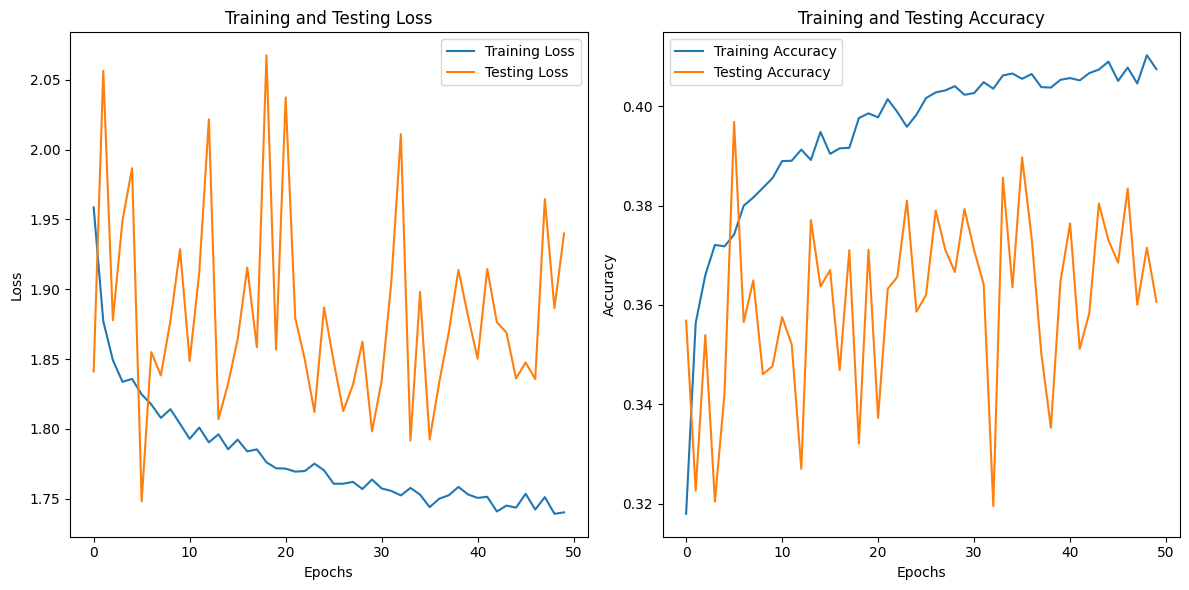

Preds: 7 | True: 7


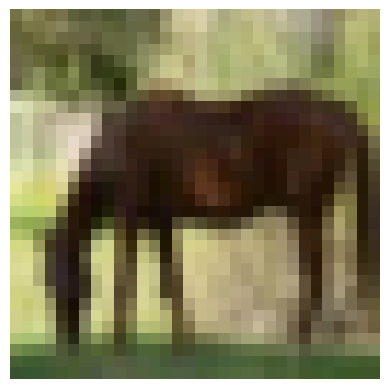

In [16]:
plot_training_testing_results(total_test_cost=total_test_cost, total_train_acc=total_train_acc, total_test_acc=total_test_acc, total_train_cost=total_train_cost)
visualize(modelv1)